In [4]:
import pandas as pd
from sqlalchemy import create_engine
import urllib


# Database connection details
server = ######
database = ######
username = ###### 
password = ######


# Construct the connection string
connection_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'
encoded_conn_str = urllib.parse.quote_plus(connection_string)

# Create the SQLAlchemy engine 
engine = create_engine(f'mssql+pyodbc:///?odbc_connect={encoded_conn_str}')

query = '''
SELECT 
    a.[prc_name],
    a.[department_name],
    a.[dept_specialty_name],
    a.[center_name],
    a.[visit_provider_name],
    a.[visit_prov_id],
    a.[appt_status],
    a.[days_to_appt] as appt_lead_days,
    a.[appt_time],
    a.[appt_date],   
    a.[appt_length],
    a.[appt_made_date],
    p.[probability_percent],
    p.[evaluation_utc_dttm]
FROM 
    [rpt].[appointment] a
INNER JOIN
    [src].[appointment_predict] p
    ON a.[csn] = p.[pat_enc_csn_id]
'''
df = pd.read_sql(query, engine)


# Close the connection
engine.dispose() 

In [8]:
df.appt_status.value_counts(normalize=True)

appt_status
Completed            0.588196
Canceled             0.243659
Late Cancel          0.087818
No Show              0.059454
Scheduled            0.019120
Left without seen    0.001708
Arrived              0.000046
Name: proportion, dtype: float64

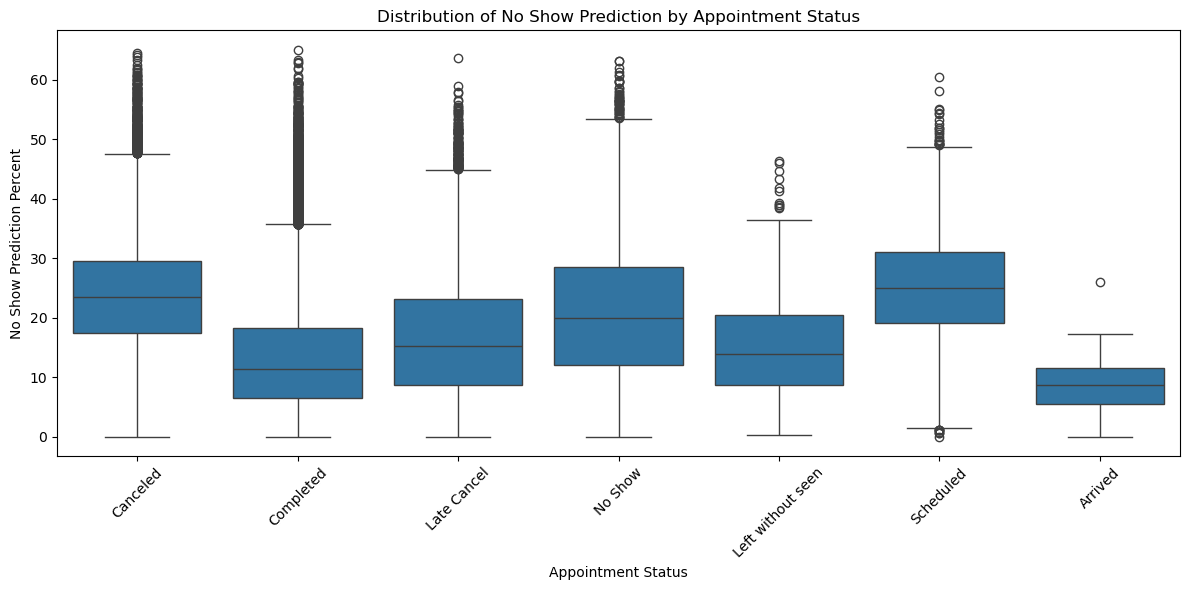

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='appt_status', y='probability_percent')
plt.xticks(rotation=45)
plt.title('Distribution of No Show Prediction by Appointment Status')
plt.xlabel('Appointment Status')
plt.ylabel('No Show Prediction Percent')
plt.tight_layout()
plt.show()

**No Show**
Higher median (~22–25%) and wider IQR compared to other categories.

Some predictions go well above 50%.

Model seems to correctly assign higher risk to these appointments, but the scores could still be more confident.

**Completed**
Lower median (~10%) with a relatively tight spread.

This is good — the model generally predicts a low risk of no-show for visits that actually happened.

**Arrived**
Even lower predictions — mostly under 15%, tight distribution.

Suggests the model performs well for cases that definitely occurred (possibly walk-ins or urgent visits).

**Canceled / Late Cancel**
Mid-range medians (~20%).

May indicate these appointments shared risk factors similar to no-shows, which makes sense behaviorally.

**Scheduled**
Median is high (~27%) with wide spread.

Model flags many of these as high-risk — appropriate if these haven’t occurred yet.

**Left Without Seen**
Median is closer to Completed, but with outliers.

Could be operational misses or borderline no-show behavior — good to review separately.

In [26]:
# evaluate the performance the prediction model as a binary classifiier
# cannot include scheduled/arrived
df = df[~df.appt_status.isin(['Arrived', 'Scheduled'])]
df['target'] = df['appt_status'].isin(['No Show', 'Canceled', 'Late Cancel']).astype(int)

In [28]:
df.appt_status.value_counts(normalize=True)

appt_status
Completed            0.599690
Canceled             0.248420
Late Cancel          0.089534
No Show              0.060616
Left without seen    0.001741
Name: proportion, dtype: float64

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df['target'], df['probability_percent'])

0.7385348683671653

What Does ROC AUC = 0.7385 Mean?

Range: ROC AUC values range from 0.5 to 1.0:

0.5 = random guessing

0.7–0.8 = acceptable/good discrimination

0.8–0.9 = excellent

>0.9 = outstanding (possibly overfitting)

Your score of 0.7385 suggests that:

🔍 "There’s a 73.85% chance that a randomly chosen patient who eventually cancels or no-shows will be assigned a higher predicted no-show probability than a randomly chosen patient who does not."

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

threshold = 0.3  # or another value based on your business context
df['predicted_class'] = df['probability_percent'] >= threshold

precision = precision_score(df['target'], df['predicted_class'])
recall = recall_score(df['target'], df['predicted_class'])
f1 = f1_score(df['target'], df['predicted_class'])

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

Precision: 0.40, Recall: 1.00, F1: 0.57


High recall (1.00): Your model identified every at-risk appointment, which is great for minimizing missed no-shows.

Low precision (0.40): Many of those identified as high-risk did not actually cancel or no-show. This could waste resources if interventions (e.g., reminder calls) are costly.

F1 Score (0.57): Indicates a trade-off — the model favors catching all potential no-shows over being precise.

In [39]:
# measure with ANOVA
from scipy.stats import f_oneway

groups = [group['probability_percent'] for name, group in df.groupby('appt_status')]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA p-value: {p_val}")

ANOVA p-value: 0.0


In [41]:
# pairwise comparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(df['probability_percent'], df['appt_status'])
print(tukey.summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1            group2      meandiff p-adj   lower    upper   reject
----------------------------------------------------------------------------
         Canceled         Completed -10.3015    0.0 -10.4403 -10.1627   True
         Canceled       Late Cancel  -6.7853    0.0   -7.012  -6.5585   True
         Canceled Left without seen  -8.1044    0.0  -9.5036  -6.7053   True
         Canceled           No Show  -2.5821    0.0  -2.8457  -2.3185   True
        Completed       Late Cancel   3.5162    0.0   3.3078   3.7247   True
        Completed Left without seen   2.1971 0.0002   0.8008   3.5933   True
        Completed           No Show   7.7194    0.0   7.4714   7.9673   True
      Late Cancel Left without seen  -1.3192 0.0787  -2.7269   0.0886  False
      Late Cancel           No Show   4.2032    0.0   3.8971   4.5092   True
Left without seen           No Show   5.5223    0.0   4.1082   6.9365   True

### 🧠 Major Findings (Focus on `reject = True`)

| Comparison                      | Mean Difference | Interpretation                                                                                     |
|---------------------------------|-----------------|-----------------------------------------------------------------------------------------------------|
| Canceled vs Completed           | -10.30          | Canceled appointments had significantly higher predicted risk than Completed ones.                  |
| Canceled vs Late Cancel         | -6.79           | Canceled had higher predictions than Late Cancel — may indicate the model distinguishes between voluntary and reactive cancellations. |
| Canceled vs Left without seen   | -8.10           | Much higher risk for Canceled compared to those who left without being seen.                        |
| Canceled vs No Show             | -2.58           | Canceled still had higher predictions than No Show — could suggest the model weighs cancellation behavior strongly. |
| Completed vs No Show            | 7.72            | Huge difference — model assigns much higher probability to No Shows than Completed. ✅ Very expected and desirable. |
| Completed vs Left without seen  | 2.20            | Slight but significant difference — model correctly assigns more risk to those who left.            |
| Late Cancel vs No Show          | 4.20            | No Show predictions were significantly higher — the model differentiates these behaviors well.      |
| Left without seen vs No Show    | 5.52            | Again, No Show cases were predicted as higher risk, which aligns with clinical expectations.        |
| Completed vs Late Cancel        | 3.52            | Late Cancels had significantly higher predicted no-show probabilities.                              |

Summary:
The model distinguishes very well between No Show/Canceled/Late Cancel and Completed.

It assigns graduated probability scores that align with outcome severity, without any transformation.

Only one pair (Late Cancel vs Left without seen) was not significantly different — worth exploring further (e.g., feature overlap or ambiguous patient behavior).

Overall:
This is strong evidence that your model's probability output meaningfully differentiates among appointment outcomes. This makes it useful for operational triage, patient outreach, and model explainability.

Let me know if you’d like to visualize these differences or build a calibration plot next!

C:\Users\dsarmien\AppData\Local\Temp\ipykernel_21584\3190553590.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df.groupby('prob_bin')['appt_status'].value_counts(normalize=True).unstack().fillna(0)


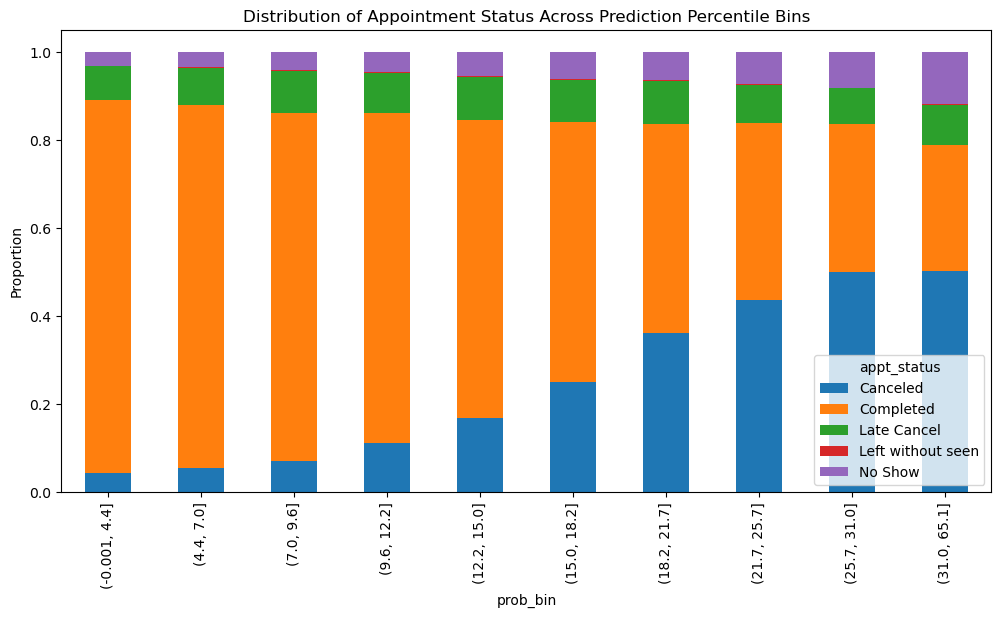

In [47]:
#  bin the probability percent and examine the outcome frequency per bin:
df['prob_bin'] = pd.qcut(df['probability_percent'], q=10)

bin_summary = df.groupby('prob_bin')['appt_status'].value_counts(normalize=True).unstack().fillna(0)
import matplotlib.pyplot as plt

bin_summary.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of Appointment Status Across Prediction Percentile Bins')
plt.ylabel('Proportion')
plt.show()

✅ What the Chart Tells Us:

🟧 Completed (Orange):

Dominant in low prediction bins (left side): In the lowest bins (0.0 – 12.2), most patients had a "Completed" status.

This confirms that the model correctly assigns low no-show risk to patients who eventually complete their appointments.

🟦 Canceled (Blue):

Steadily increases across bins, becoming the majority class in the highest bins (>25.7).

Indicates that patients who were canceled were correctly assigned higher no-show probabilities by the model.

🟩 Late Cancel (Green):

Fairly stable across all bins.

Suggests that the model does not vary its risk score as much for this group — possibly due to less distinctive features.

🟪 No Show (Purple):

Starts to appear more often in higher bins, especially above the 25.7 mark.

This aligns well with expectations: no-shows are more concentrated in higher predicted risk.

🟥 Left without seen (Red):

Appears minimally and stays relatively flat.

The model doesn’t make strong predictions one way or another for these cases, possibly due to limited data or ambiguous behavior.

| Bin (Predicted Risk %) | Dominant Outcome      | Model Behavior                                                                 |
|------------------------|------------------------|--------------------------------------------------------------------------------|
| Low bins (0–12%)       | Completed              | Model confidently predicts these as low-risk and they tend to show up. ✅      |
| Middle bins (12–25%)   | Mixed                  | Transition zone: canceled and late cancels begin to increase. ⚠️              |
| High bins (25–65%)     | Canceled / No Show     | Model identifies these as high-risk, and they are — strong calibration. ✅     |

**The model’s predicted probabilities increase in alignment with the frequency of negative appointment outcomes, especially for "Canceled" and "No Show." This indicates strong calibration and interpretability, making it suitable for real-world risk stratification and intervention planning**

# Summary of Observations:

The model has strong recall and reasonable discrimination (ROC AUC ≈ 0.74).

Probabilities increase meaningfully across outcomes — high scores align with higher risk.

Tukey HSD confirms statistically significant differences in predicted risk between outcome groups.

Binned calibration shows more incomplete outcomes in higher bins, confirming model interpretability

### 1. Implement a Tiered Risk Intervention System

Use prediction percentiles to assign patients into **low**, **moderate**, and **high** risk groups:

| Risk Group     | Prediction Percent Range | Suggested Action                                                              |
|----------------|---------------------------|--------------------------------------------------------------------------------|
| Low Risk       | 0–12%                     | No extra action. Rely on standard communication (text, email).                |
| Moderate Risk  | 12–25%                    | Send reminders closer to the date, offer rescheduling or telehealth.          |
| High Risk      | >25%                      | Trigger personal outreach, rescheduling support, or transportation help.      |

### 2. Build a Daily/Weekly "At-Risk Appointments" Dashboard

List upcoming appointments with high predicted no-show probabilities.

Allow staff to sort, filter, and act (e.g., call patients, confirm appointments).

Include columns like:

Patient Name

Appointment Date/Time

Probability %

Risk Tier

Last Contacted

### 3. Enable Early Intervention Workflow Automation

For appointments made far in advance (high Days to Appointment), auto-flag them if the predicted probability is also high.

Schedule follow-up touchpoints like:

Confirmation calls 3–5 days before

Text check-ins 1–2 weeks before

Same-day reminders

### 4. Analyze Root Causes in High-Risk Segments

Segment patients with high predicted risk and:

Examine patterns by demographics, clinic location, department, time of day.

Identify if no-shows are tied to operational inefficiencies, such as:

Long wait times

Poor access to transportation

Lack of digital communication preferences

### 5. Introduce Dynamic Scheduling Flexibility

For patients predicted at high risk, provide easier rescheduling options or walk-in slots.

### 6. Model Monitoring and Retraining

Set up a monitoring pipeline to track:

Model performance (ROC AUC, precision, recall)

Intervention effectiveness (change in show rates)

Retrain the model quarterly using updated outcomes to adapt to behavior shifts (e.g., policy changes, seasonality).

Strategic Impact:

By acting on prediction percentiles instead of just binary outputs, you're:

Minimizing resource waste from no-shows and late cancels.

Improving patient engagement with targeted reminders.

Maximizing provider productivity through better schedule reliability.



In [67]:
# Evaluate appointment status by specialty
dept_status_summary = df.groupby(['dept_specialty_name', 'appt_status'])['probability_percent'].describe()
dept_status_summary

count       mean        std  min  \
dept_specialty_name    appt_status                                             
CARDIOLOGY             Canceled            1461.0  22.928542   9.125875  0.8   
                       Completed           2059.0  12.498057   8.146079  0.0   
                       Late Cancel          443.0  15.377201   9.209822  1.0   
                       Left without seen      2.0  12.550000   8.980256  6.2   
                       No Show              199.0  21.525628  11.532081  0.4   
...                                           ...        ...        ...  ...   
WOMENS HEALTH SERVICES Canceled           10921.0  20.198196   8.618405  0.0   
                       Completed          26759.0  10.522538   7.606525  0.0   
                       Late Cancel         3419.0  13.591781   8.664023  0.0   
                       Left without seen     76.0  13.672368   8.790292  0.7   
                       No Show             1769.0  17.190334   9.911253  0.0   

                                             25%    50%        75%        max  
dept_specialty_name    appt_status                                             
CARDIOLOGY             Canceled           16.900  23.10  28.700001  51.099998  
                       Completed           6.800  10.10  16.400000  54.299999  
                       Late Cancel         7.950  13.20  20.800000  47.500000  
                       Left without seen   9.375  12.55  15.725000  18.900000  
                       No Show            11.900  20.60  30.550000  49.700001  
...                                          ...    ...        ...        ...  
WOMENS HEALTH SERVICES Canceled           14.100  20.10  25.900000  53.400002  
                       Completed           4.700   9.00  14.600000  65.099998  
                       Late Cancel         6.900  12.20  18.900000  51.200001  
                       Left without seen   7.275  12.55  17.949999  39.000000  
                       No Show             9.400  16.00  23.600000  53.700001  

[63 rows x 8 columns]

In [69]:
# pivot to compare mean risk by status per specialty
pivot = df.pivot_table(
    index='dept_specialty_name',
    columns='appt_status',
    values='probability_percent',
    aggfunc='mean'
).fillna(0)

pivot = pivot.sort_values(by='No Show', ascending=False) 

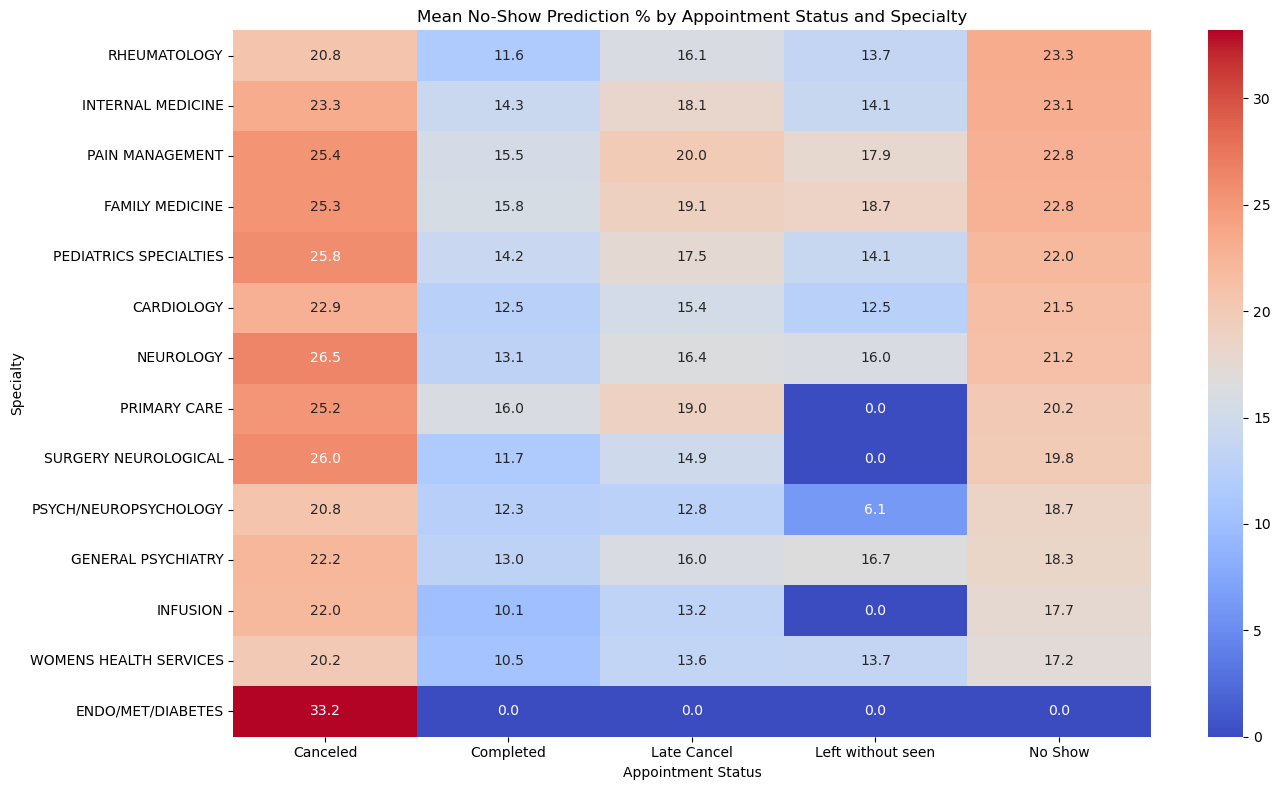

In [71]:
# visualize with heatmap

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap='coolwarm', annot=True, fmt=".1f")
plt.title("Mean No-Show Prediction % by Appointment Status and Specialty")
plt.ylabel("Specialty")
plt.xlabel("Appointment Status")
plt.tight_layout()
plt.show()

### Interpretation: Heatmap of Mean No-Show Prediction % by Appointment Status and Specialty

This heatmap shows the **mean predicted no-show probability** (`probability_percent`) across combinations of `appt_status` and `dept_specialty_name`. It helps assess how well the model captures risk by both appointment outcome and clinical specialty.

---
### ✅ Key Insights by Specialty

| Specialty                | Notable Trends                                                                 |
|--------------------------|---------------------------------------------------------------------------------|
| **ENDO/MET/DIABET*    | 🔴 Very high prediction for **Canceled (33.2%)** and **zero** for all others. Likely indicates **data quality issues** or model confusion in this specialty. Requires review. |
| **NEUROLOGY / SURGERY NEUROLCAL** | 🔥 High Canceled predictions (26.5%, 26.0%) and low Completed values. Suggests high risk and **valid model warning** of unreliability in these appointments. |
| **PRIMARY CARE / FAMILY MED / PAIN MANAGEMENT** | Moderate-high predicted risk across all non-Completed statuses. These are **high-volume specialties** with opportunity for proactive scheduling interventions. |
| **RHEUMATOLOGY / CARDIOLOGY / INTERNAL MEDICINE** | More **balanced risk spread**. Still elevated for Canceled and No Show, but not alarmingly high. Indicates potential for **light-touch reminders**. |
| **WOMENS HEALTH / INFUSION** | Lowest predicted risk across most statuses. Suggests good operational control or **lower baseline no-show behavior**. |
| **GENERAL PSYCHIATRY / PSYCH/NEUROPSYCHOLOGY** | Lower risk across statuses, but risk rises with No Show and Canceled — model is responsive, even for behavioral health. |
| **PEDIATRICS SPECIALTIES** | Moderately high predicted risk for Canceled and No Show — worth attention. May reflect **guardian-driven scheduling behavior |

---

### 🔍 Insights by Appointment Status (Across Specialties)

- **Canceled**: Risk is consistently high, especially in Endocrinology, Neurology, and Primary Care. Indicates departments may benefit from **outreach or scheduling policy review**.
- **Completed**: Lower predicted risk across all specialties (10–16%), confirming **model confidence** in these outcomes.
- **Late Cancel**: Risk is moderate and less differentiated; **could benefit from feature refinement**.
- **Left Without Seen**: Risk is generally low, but notable outliers (e.g., Psych/Neuropsychology) suggest **room for attention**.
- **No Show**: High predicted risk aligns with expected behavior — **model performs well in fling these**.

---

### 📌 Actionable Recommendations

1. **Investigate High-Risk Specialties**:
   - Focus on specialties with high predicted risk (Endocrinology, Neurology, Pain Management).
   - Apply targeted strategies like **appointment confirmation, transportation support, or overbooking buffers**.

2. **Review Endo/Met/Diabetes Data**:
   - The presence of 0% predicted risk across multiple statuses (except Canceled) indicates a potential **data labeling or pipeline error**.

3. **Prioritize Intervention for At-Risk Departments**:
   - Use this table to **rank specialties** for operational intervention or pilot outreach programs.

4. **Tailor Communication by Department**:
   - Low-risk departments may continue with standard messaging.
   - High-risk departments should consider **personalized reminders**, **pre-visit calls**, or **AI-assisted rescheduling** tools.

5. **Celebrate Low-Risk Specialties**:
   - Reinforce and document **effective workflows** in departments like Infusion and Women's Health.

---
